In this script we measure over a large frequency range which we split up in smaller intervals, after each interval we check if the image has moved and if so we correct the position of the laser focus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import argrelmax
from os import listdir
from os.path import isfile, join
%matplotlib inline
import threading

import json

# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')

import hardware_modules.ZiControl as zi
import functions.ScanPhotodiode_DAQ as GalvoScan
import hardware_modules.PiezoController as pc
import functions.tracking as trk
from  hardware_modules.GalvoMirrors import SetGalvoPoint
# from  hardware_modules.PhotodiodeInput import ReadPhotodiode
import hardware_modules.PhotodiodeInput as PDIn



from time import localtime, strftime
import time
# file = './2015-05-21_20-32-29-5.8e-4Torr_NoPinhole_R100k.csv'
# folder = './'


timePerPt = 0.001

dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/LookingForResonances'

tag = 'Si3Ni4'

# 
- take image to figure out the region where to look for the beam
- set region of interest (RIO)
- measure RIO, find beam, point with laser at beam, measure mechanical response, repeat for next range of mechanical frequencies

# Measure the full image

In [23]:
# =============================================
# =============================================
# set the initial scan range
# =============================================
rio_initial = {
        "xo": 0, 'yo': 0,
        "dx": 0.8, 'dy': 0.8,
        'xPts': 120, 'yPts': 120
    }



xVmin,xVmax,xPts,yVmin,yVmax,yPts = trk.rio_to_galvoparameter(rio_initial)

scanner = GalvoScan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts,timePerPt, canvas = None)

image_data = scanner.scan()

# set RoI

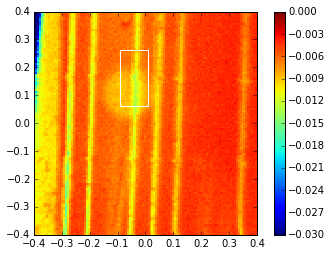

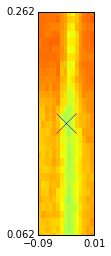

In [33]:
# =============================================
# =============================================
# display image 
# =============================================

# ---------------------------------------------
# adjust the color scale
clim_min, clim_max = -0.03, 0
# ---------------------------------------------

# ---------------------------------------------
# set region of interest

rio = {
        "xo": -0.040, 'yo': 0.160,
        "dx": 0.1, 'dy': 0.2,
        'xPts': 30, 'yPts': 60
    }

rio = {
        "xo": -0.040, 'yo': 0.162,
        "dx": 0.1, 'dy': 0.2,
        'xPts': 30, 'yPts': 60
    }
# ---------------------------------------------

# =============================================
# =============================================




# ---------------------------------------------
# show image
fig_overwiew = plt.figure()
ax = plt.subplot(1,1,1)


X, Y = np.meshgrid( np.linspace(xVmin,xVmax,xPts),  np.linspace(yVmin,yVmax,yPts))

p = plt.pcolor(X, Y, image_data)
# p = plt.imshow(image_data, interpolation="nearest")
plt.colorbar()
p.set_clim(clim_min, clim_max)
plt.xlim([xVmin, xVmax])
plt.ylim([yVmin, yVmax])

# plt.axes().set_aspect('equal')

plt.axes().set_aspect(abs((xVmax-xVmin) / (yVmax-yVmin)))
# print abs((xVmax-xVmin) / (yVmax-yVmin))
# ---------------------------------------------
# draw RIO
trk.plot_region(plt, rio, color = 'w')

#  plot close up
fig_RoI = plt.figure()
ax = plt.subplot(1,1,1)
p = plt.pcolor(X, Y, image_data)
# p = plt.imshow(image_data, interpolation="nearest")
# plt.colorbar()
p.set_clim(clim_min, clim_max)

rio_xVmin, rio_xVmax, rio_xPts, rio_yVmin, rio_yVmax, rio_yPts = trk.rio_to_galvoparameter(rio)

plt.xlim([rio_xVmin, rio_xVmax])
plt.ylim([rio_yVmin, rio_yVmax])
plt.axes().set_xticks([rio_xVmin, rio_xVmax])
plt.axes().set_yticks([rio_yVmin, rio_yVmax])

plt.axes().set_aspect(rio_yPts / rio_xPts)
plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20)

# first measurement of RoI for reference of tracking

<hardware_modules.GalvoMirrors.SetGalvoPoint instance at 0x000000002D8589C8>

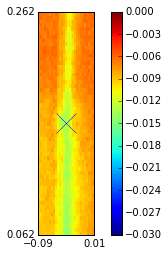

In [34]:
# =============================================
# =============================================
# once we are happy with the RIO we start the tracking, first however save the image and the metadata
# =============================================
start_time = strftime("%Y-%m-%d_%H-%M-%S", localtime())

filename = '{:s}_{:s}'.format(start_time,tag)

fig_overwiew.savefig('{:s}/{:s}_Overview.png'.format(dirpath, filename))

with open('{:s}/{:s}_Overview.rio'.format(dirpath, filename), 'w') as outfile:
     json.dump(rio_initial, outfile, sort_keys = True, indent = 4, ensure_ascii=False)
        

# =============================================
# =============================================
# take a first image of the RIO
# =============================================


# ---------------------------------------------
# scan RIO
rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts = trk.rio_to_galvoparameter(rio)
scanner = GalvoScan.ScanNV(rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts,timePerPt, canvas = None)
rio_image_data = scanner.scan()


# ---------------------------------------------
# show image

# fig = plt.figure(figsize=(20,10))


fig_RoI = plt.figure()
X, Y = np.meshgrid( np.linspace(rio_xVmin,rio_xVmax,rio_xPts),  np.linspace(rio_yVmin,rio_yVmax,rio_yPts))

p = plt.pcolor(X, Y, rio_image_data)
# p = plt.imshow(image_data, interpolation="nearest")
plt.colorbar()
p.set_clim(clim_min, clim_max)

plt.xlim([rio_xVmin, rio_xVmax])
plt.ylim([rio_yVmin, rio_yVmax])

plt.axes().set_aspect(rio_yPts / rio_xPts)
plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20, mew = 0.5)
# plt.plot(rio['xo'], rio['yo'], 'circ' , ms = 20, mew = 2)
plt.axes().set_xticks([rio_xVmin, rio_xVmax])
plt.axes().set_yticks([rio_yVmin, rio_yVmax])
# save RIO image and data
counter = 0
filename = '{:s}_{:s}'.format(start_time,tag)
fig_RoI.savefig('{:s}/{:s}_RIO_{:03d}.png'.format(dirpath, filename, counter))
np.savetxt('{:s}/{:s}_RIO_{:03d}.csv'.format(dirpath, filename, counter), rio_image_data, fmt='%.18e', delimiter=',')

with open('{:s}/{:s}_RIO_{:03d}.rio'.format(dirpath, filename, counter), 'w') as outfile:
     json.dump(rio, outfile, sort_keys = True, indent = 4, ensure_ascii=False)
        
        
SetGalvoPoint(rio['xo'], rio['yo'])

In [32]:
rio['xo']

-0.035

#  loop breaking up the full scan range into shorter intervals, after each interval correct for drifts

In [5]:
# ======================================================================
# set frequency range of full scan =====================================
# ======================================================================
freqEnd = 2e6
freqStart = 1.8e6
freq_df = 5

interval_sampleNum = 2e3


zi_parameter = {
    'amplitude' : 0.5,
    'offset' : 2.0,
    'freq' : 1e5,
    'ACCoupling' : 0, 
    'inChannel' : 0,
    'outChannel' : 0,
    'auxChannel': 0,
    'add' : 1,
    'range' : 1.0
}






# ======================================================================
# start script =========================================================
# ======================================================================

with open('{:s}/{:s}_{:03d}.zi'.format(dirpath, filename, counter), 'w') as outfile:
    json.dump(zi_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)

zi_hf2 = zi.ZIHF2(zi_parameter['amplitude'],
                  zi_parameter['offset'],
                  zi_parameter['freq'],
                  zi_parameter['ACCoupling'],
                  zi_parameter['inChannel'],
                  zi_parameter['outChannel'],
                  zi_parameter['auxChannel'],
                  zi_parameter['add'],
                  zi_parameter['range']
                 )


interval_freqStart = freqStart
while interval_freqStart < freqEnd:
    
    # ========================================================================================
    # define new interval for sweep 
    interval_freqStart =  freqStart + counter * interval_sampleNum * freq_df
    interval_freqEnd  =  freqStart + ((counter+1) * interval_sampleNum-1) * freq_df
    sweep_parameter = {
        'freqStart' : interval_freqStart,
        'freqEnd' : interval_freqEnd,
        'sampleNum' : interval_sampleNum,
        'samplesPerPt' : 4, 
        'xScale' : 0,
        'direction' : 0,
        'loopcount': 1,
        'timeout' : 1e8
    }
    
    with open('{:s}/{:s}_sweep_{:03d}.sweep'.format(dirpath, filename, counter), 'w') as outfile:
        json.dump(sweep_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)
    
    
    print '{:s}\t sweeping\t {:03.3f} - {:03.3f}kHz'.format(
            strftime("%Y-%m-%d %H:%M:%S", localtime()),
            sweep_parameter['freqStart'] * 1e-3,
            sweep_parameter['freqEnd']* 1e-3)
    
    
    # ========================================================================================
    # set laser position
    SetGalvoPoint(rio['xo'], rio['yo']) 
    
    # ========================================================================================
    # look for mechanical resonance and save sweep data

    zi_hf2.sweep(sweep_parameter['freqStart'],
                 sweep_parameter['freqEnd'],
                 sweep_parameter['sampleNum'],
                 sweep_parameter['samplesPerPt'],
                 sweep_parameter['xScale'],
                 sweep_parameter['direction'],
                 sweep_parameter['loopcount'],
                 sweep_parameter['timeout']
                )
    
    
    
    zi_hf2.writeData('{:s}/{:s}_RIO_{:03d}.dat'.format(dirpath, filename, counter))
    
    # ========================================================================================
    # measure RoI
    rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts = trk.rio_to_galvoparameter(rio)
    scanner = GalvoScan.ScanNV(rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts,timePerPt, canvas = None)
    rio_image_data_new = scanner.scan()
    
    # ========================================================================================
    # compare to previous image and determine new RoI
    rio = trk.find_beam_position(rio_image_data, rio_image_data_new, rio)
    
    # ========================================================================================
    # overwrite data for next iteration
    rio_image_data = rio_image_data_new

    # ========================================================================================
    # create image of RoI
    fig_rio = plt.figure()
    X, Y = np.meshgrid( np.linspace(rio_xVmin,rio_xVmax,rio_xPts),  np.linspace(rio_yVmin,rio_yVmax,rio_yPts))

    p = plt.pcolor(X, Y, rio_image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)

    plt.xlim([rio_xVmin, rio_xVmax])
    plt.ylim([rio_yVmin, rio_yVmax])

    plt.axes().set_aspect(rio_yPts / rio_xPts)
    plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20)
    
    # ========================================================================================
    # save RoI data and image 
    filename = '{:s}_{:s}'.format(start_time,tag)
    fig_rio.savefig('{:s}/{:s}_RIO_{:03d}.png'.format(dirpath, filename, counter))
    np.savetxt('{:s}/{:s}_RIO_{:03d}.csv'.format(dirpath, filename, counter), rio_image_data, fmt='%.18e', delimiter=',')

    with open('{:s}/{:s}_RIO_{:03d}.rio'.format(dirpath, filename, counter), 'w') as outfile:
        json.dump(rio, outfile, sort_keys = True, indent = 4, ensure_ascii=False)
    
    # ========================================================================================
    # close fig 
    plt.close(fig_rio)
    
    print '\t current laser position:\t  {:0.3f}\t {:0.3f}'.format(rio['xo'], rio['yo'])
    
    counter +=1
#

autoConnect connected to a server on port 8005 using API level 1.
autoDetect selected the device dev35 for the measurement.
[['/dev35/sigins/0/imp50', 1], ['/dev35/sigins/0/ac', 0], ['/dev35/sigins/0/range', 1.0], ['/dev35/demods/0/order', 4], ['/dev35/demods/0/rate', 10000.0], ['/dev35/demods/0/harmonic', 1], ['/dev35/demods/0/phaseshift', 0], ['/dev35/sigouts/0/on', 1], ['/dev35/sigouts/0/range', 1.0], ['/dev35/sigouts/0/enables/6', 1], ['/dev35/sigouts/0/amplitudes/6', 0.5], ['/dev35/AUXOUTS/0/OFFSET', 2.0], ['/dev35/oscs/0/freq', 100000.0], ['/dev35/demods/0/oscselect', 0], ['/dev35/demods/0/adcselect', 0], ['/dev35/sigins/0/diff', 0], ['/dev35/sigouts/0/add', 1]]
2015-06-02 13:08:32	 sweeping	 1800.000 - 1809.995kHz
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
	 current laser position:	  -0.035	 0.165
2015-06-02 13:20:43	 sweeping	 1810.000 - 1819.995kHz
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sw